In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing


In [56]:
# run variables

seed = 42

In [57]:
# device settings

num_workers = multiprocessing.cpu_count() // 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

AMD Radeon RX 7800 XT
Using cuda device


In [ ]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CIFAR10("./../data", train=True, transform=transform, download=True)
test_dataset = CIFAR10("./../data", train=False, transform=transform, download=True)

train_dataset, validation_dataset =  random_split(train_dataset, [0.8, 0.2])

print('train set size:', len(train_dataset))
print('validation set size:', len(validation_dataset))
print('test set size:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train set size: 40000
validation set size: 10000
test set size: 10000


In [59]:
class BaseNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_output = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_output

In [60]:
class StudentNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        intermediate_teaching_layer_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, intermediate_teaching_layer_output

In [61]:
model_teacher = BaseNN(num_classes=10).to(device)
model_teacher.load_state_dict(torch.load("../models/base.pt"))
model_teacher.eval()

torch.manual_seed(seed)
model_student = StudentNN(num_classes=10).to(device)

In [62]:
# print important network parameters

total_params_base = "{:,}".format(sum(p.numel() for p in model_teacher.parameters()))
total_params_student = "{:,}".format(sum(p.numel() for p in model_student.parameters()))
print(f"model_teacher parameters: {total_params_base}")
print(f"model_student parameters: {total_params_student}")

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model_teacher(inputs)
        
    features_student = model_student.features(inputs)
    features_teacher = model_teacher.features(inputs)
    break

print("Student's feature extractor output shape: ", features_student.shape)
print("Teacher's feature extractor output shape: ", features_teacher.shape)

model_teacher parameters: 1,186,986
model_student parameters: 272,378
Student's feature extractor output shape:  torch.Size([128, 16, 8, 8])
Teacher's feature extractor output shape:  torch.Size([128, 32, 8, 8])


In [63]:
def train(teacher, student, epochs, learning_rate, teaching_weight, self_teaching_weight):
    trainingEpoch_loss = []
    validationEpoch_loss = []
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()

    for epoch in range(epochs):
        # training
        student.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                _, teacher_conv_output = teacher(inputs)

            student_output, intermediate_teaching_layer_output = student(inputs)

            teaching_loss = mse_loss(intermediate_teaching_layer_output, teacher_conv_output)
            self_teaching_loss = ce_loss(student_output, labels)
            loss = teaching_weight * teaching_loss + self_teaching_weight * self_teaching_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        trainingEpoch_loss.append(running_loss / len(train_loader))
    
        # validation
        student.eval()
        validation_loss = 0.0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                _, teacher_conv_output = teacher(inputs)

            student_output, intermediate_teaching_layer_output = student(inputs)

            teaching_loss = mse_loss(intermediate_teaching_layer_output, teacher_conv_output)
            self_teaching_loss = ce_loss(student_output, labels)
            loss = teaching_weight * teaching_loss + self_teaching_weight * self_teaching_loss

            validation_loss += loss.item()

        validationEpoch_loss.append(validation_loss / len(validation_loader))
        
    return trainingEpoch_loss, validationEpoch_loss

In [64]:
trainingEpoch_loss, validationEpoch_loss = train(teacher=model_teacher, student=model_student, epochs=10, learning_rate=0.001, teaching_weight=0.25, self_teaching_weight=0.75)

Epoch 1/10, Loss: 1.8214595477801923
Epoch 2/10, Loss: 1.4240510151409114
Epoch 3/10, Loss: 1.2648170379023203
Epoch 4/10, Loss: 1.162593689970315
Epoch 5/10, Loss: 1.076127474681257
Epoch 6/10, Loss: 1.0116532519221686
Epoch 7/10, Loss: 0.9445975950350777
Epoch 8/10, Loss: 0.8970218965420708
Epoch 9/10, Loss: 0.8483976653208748
Epoch 10/10, Loss: 0.7992614083015881


In [65]:
torch.save(model_student.state_dict(), "../models/student.pt")

In [66]:
def test(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [67]:
test(model_student)

Test Accuracy: 69.24%


69.24

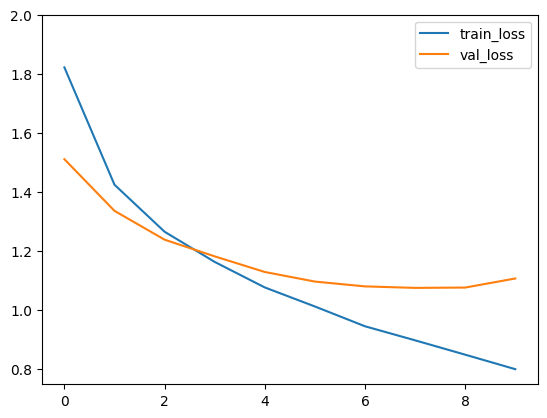

In [68]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.ylim(top=2)
plt.show()